# Evaluate a 3D Convolutional Neural Network (3dCNN) to classify the entire HCP task spectrum

<p style='text-align: justify;'>In this notebook I evaluated a neural network whose parameters appear to be optimal to discriminate between all classes of the HCP dataset.

</p>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os, wandb, torch, time
import pandas as pd
import numpy as np
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary
import seaborn as sns
import matplotlib.pyplot as plt

from delphi import mni_template
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config, z_transform_volume
from delphi.utils.plots import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

# you can find all these files in ../utils
from utils.tools import attribute_with_method, concat_stat_files, compute_mi
from utils.wandb_funcs import reset_wandb_env, wandb_plots, get_wandb_csv
from utils.random import set_random_seed

from tqdm.notebook import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<p style='text-align: justify;'>To make sure that we obtain (almost) the same results for each execution we set the random seed of multiple different librabries (i.e., torch, random, numpy)</p>

In [3]:
g = set_random_seed(2020) # the project started in the year 2020, hence the seed

## Initializations

In this section, we define and initialize our required variables. We first need to define which classes we want to predict, i.e., the conditions of the motor mapper. We then define a PyTorch dataset; in this case `NiftiDataset` is a custom written Dataset-Class (see https://github.com/PhilippS893/delphi). As is common practice in machine learning projects, we split our data into a training and validation dataset (ratio=80 to 20, respectively).

Note: In case it is necessary to create a null-model, i.e., a neural network that is trained on data where the labels are randomized, one can set the parameter `shuffe_labels=False` to `True`. This is usually done to have a baseline for the null hypothesis that "everything is random".

Also, we first check which of the network in the hyperparameter optimization performs best. We will then use this network for the rest of the analyses.

In [4]:
entity = "philis893"
project = "thesis"
group_name = "hp-optimization"

important_keys = ['group', 'job_type', 'run_name', 'best_valid_accuracy', 'test_accuracy', 'test_loss', 'train_acc', 'valid_acc',
                  'valid_loss', 'best_valid_epoch', 
                  'train_loss']

tbl = get_wandb_csv(entity, project, group_name, important_keys)

# which is the best model
tbl_sorted = tbl.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
tbl_sorted.head(2)


File already exist. Loading instead


,group,job_type,run_name,test_accuracy,train_acc,valid_acc,valid_loss,best_valid_epoch,best_valid_accuracy,test_loss,train_loss
31,hp-optimization,hcp-explo,batchsize-8_kernelsize-3_lr-0.001_dropout-0.5_...,0.905263,0.924812,0.868421,0.308107,19,0.889098,0.296990,0.177660
48,hp-optimization,hcp-explo,batchsize-16_kernelsize-3_lr-0.001_dropout-0.3...,0.884211,0.953477,0.849624,0.460952,15,0.889098,0.280536,0.146973


In [5]:
tbl_sorted["run_name"].iloc[0]

'batchsize-8_kernelsize-3_lr-0.001_dropout-0.5_weightdecay-0.0001'

In [6]:
best_model_name = os.path.join("../02_hp_exploration/models/", tbl_sorted["run_name"].iloc[0])
model = BrainStateClassifier3d(best_model_name)
model.eval();

Loading from config file ../02_hp_exploration/models/batchsize-8_kernelsize-3_lr-0.001_dropout-0.5_weightdecay-0.0001/config.yaml


In [7]:
data_test = NiftiDataset("../t-maps/test", model.config["class_labels"], 0, device=DEVICE, transform=ToTensor())
#data_test = NiftiDataset("../t-smoothed//test", model.config["class_labels"], 0, device=DEVICE, transform=ToTensor())

<p style='text-align: justify;'>Since we already trained the network, we can directly jump into the analysis</p>

## Analyzing the network performances

## Loss and accuracy curves for the real and shuffled labels

In [ ]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
# plot the train and valiation losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
label_order = ["real"]#, "shuffled"]

dfs = []
for i, order in enumerate(label_order):
    #folds_real = sorted(glob(os.path.join(f"models/hcp-train-{order}/*fold*"))) 
    folds_real = sorted(glob(os.path.join(f"models/CV-7folds-{order}/*fold*"))) 
    dfs.append(concat_stat_files(folds_real, "loss_acc_curves.csv"))
    dfs[i]["label_order"] = order

curves = pd.concat(dfs)
curves["epoch"] = curves.index

sns.lineplot(ax=axes[0], data=curves.melt(value_vars=["train_loss", "valid_loss"], id_vars=["epoch", "label_order"], var_name="loss", value_name="CrossEntropyLoss"), 
             x="epoch", y="CrossEntropyLoss", hue="label_order", style="loss", 
             linewidth=2, errorbar=("ci", 95), n_boot=5000)
sns.lineplot(ax=axes[1], data=curves.melt(value_vars=["train_acc", "valid_acc"], id_vars=["epoch", "label_order"], var_name="accuracy", value_name="acc"), 
             x="epoch", y="acc", hue="label_order", style="accuracy", 
             linewidth=2, errorbar=("ci", 95), n_boot=5000)

for i in range(2):
    axes[i].spines[["top", "right"]].set_visible(False);
    axes[i].legend(frameon=False, loc="center right", fontsize=18)
    
fig.tight_layout()

#plt.savefig('figures/loss-acc-curves-across-folds.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
# compute the test classification accuracy of the folds
label_condition = ["real", "shuffled"]
stat_mats = {
    "real": [],
    "shuffled": [],
}

test_loader = DataLoader(data_test, batch_size=4, shuffle=False)

accs = np.zeros((10, 2))

for i, c in enumerate(label_condition):
    
    # get the folds
    folds = sorted(glob(os.path.join(f"models/hcp-train-{c}", "*fold*")))
    
    for j, fold in enumerate(folds):
        
        if not os.path.isfile(os.path.join(fold, "test_stats.csv")):
            model = BrainStateClassifier3d(fold)
            model.to(DEVICE)

            with torch.no_grad():
                _ , stats = model.fit(test_loader, train=False)

            df_test = pd.DataFrame(stats.tolist(), columns=[*class_labels, *["real", "predicted"]])
            df_test.to_csv(os.path.join(fold, "test_stats.csv"), index=False)
            stat_mats[c].append(df_test)
            accs[j, i] = compute_accuracy(stats[:, -2], stats[:, -1])
        else:
            stat_mats[c].append(pd.read_csv(os.path.join(fold, "test_stats.csv")))
            accs[j, i] = compute_accuracy(stat_mats[c][j]["real"], stat_mats[c][j]["predicted"])
        

df_accs = pd.DataFrame(accs.tolist(), columns=label_condition)
df_accs.to_csv("stats/hcp-accs.csv", index=False)

df_acc_transformed = np.arcsin(df_accs)
df_acc_transformed.to_csv("stats/hcp-accs-transformed.csv", index=False)

<p style='text-align: justify;'>The resulting graph of the code below consists of 3 panels. The panel on the left shows the average test classification performance across all folds for the 3D CNNs trained with real and shuffled input-label mappings. The blue and violet dots represent the individual test accuracies for a given fold. The dashed line at 0.2 represents the chance level. <br>
We clearly see that the networks trained with real input-label mappings perform reliably above the chance level, whereas the networks trained with shuffled input-label mappings perform at chance level.
<br><br>
The other two panels show the confusion matrices for the real (left) and shuffled (right) input-label mappings. This is just another representation that the input-label mapping indeed matters for the network to learn to distinguish between the conditions of the motor mapper.
</p>

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'width_ratios': [.5, 1, 1]})

# plot the average test accuracy 
sns.barplot(ax=ax[0], data=df_accs, color=[.5,.5,.5], alpha=.2, errorbar=("ci", 95), n_boot=5000, capsize=.1, width=.4)
sns.stripplot(ax=ax[0], data=df_accs, zorder=1, alpha=.7, size=8, legend=False, palette="cool")
ax[0].axhline(1/19, linestyle="--", color="black", zorder=0, label="chance level")
ax[0].set(ylabel="accuracy", xlabel="label order", title="average classification performance");
ax[0].legend(frameon=False)
ax[0].spines[["top", "right"]].set_visible(False);

# plot the confusion matrix across all folds for the "real" label order
df = pd.concat(stat_mats["real"])
conf_mat, conf_ax = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], normalize=False, ax=ax[1], **{"vmin": 0, "vmax": 200})
ax[1].set_title("real label order");

# plot the confusion matrix across all folds for the "shuffled" label order
df = pd.concat(stat_mats["shuffled"])
conf_mat, conf_ax = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], normalize=False, ax=ax[2], **{"vmin": 0, "vmax": 200})
ax[2].set_title("shuffled label order");
fig.colorbar(conf_ax, ax=ax[2], )

fig.tight_layout()

plt.savefig('figures/test-performance-across-folds.pdf', facecolor=fig.get_facecolor(), transparent=True)

## Investigate what information was deemed relevant (XAI)


In [8]:
from captum.attr import GuidedBackprop
from zennit.rules import Epsilon, Gamma, Pass
from zennit.types import Convolution, Linear, Activation
from zennit.composites import LayerMapComposite
from delphi.utils.tools import save_in_mni

composite_lrp_map = [
    (Activation, Pass()),
    (Convolution, Gamma(gamma=.25)),
    (Linear, Epsilon(epsilon=0)),
]

LRP = LayerMapComposite(
    layer_map=composite_lrp_map,
)
LRP.__name__ = 'LRP'

In [47]:
label_order = "real"

n_folds = 7

attributor_method = [LRP, GuidedBackprop]

for i, method in enumerate(attributor_method):

    method_name = str(method.__name__).lower()

    for fold in range(n_folds):
        # load the trained network
        #model = BrainStateClassifier3d(f"models/hcp-train-{label_order}/seed-2020_fold-{fold:02d}")
        #model = BrainStateClassifier3d(f"models/smoothed-4mm-{label_order}/seed-2020_fold-{fold:02d}")
        model = BrainStateClassifier3d(f"models/CV-7folds-{label_order}/seed-2020_fold-{fold:02d}")
        model.to(torch.device("cpu"));
        model.eval()
        
        out_dir_name = f"{method_name}/{label_order}/seed-2020_fold-{fold:02d}"
        if not os.path.exists(out_dir_name):
            os.makedirs(out_dir_name)

        class_labels = model.config["class_labels"]
            
        for j in range(len(class_labels)):

            print(f"Running {method_name} on {class_labels[j]}")

            out_fname = os.path.join(out_dir_name, '%s.nii.gz' % class_labels[j])
            if os.path.isfile(out_fname):
                print(f"{out_fname} already exists. Skipping")
                continue

            dl = DataLoader(
                NiftiDataset('../t-maps/test', [class_labels[j]], 0, device=torch.device("cpu"), transform=ToTensor()),
                batch_size=20, shuffle=False, num_workers=0
            )

            for i, (volume, target) in enumerate(dl):

                attribution = attribute_with_method(method, model, volume, target)

                subject_attr = np.moveaxis(attribution.squeeze().detach().numpy(), 0, -1)
                subject_attr = z_transform_volume(subject_attr)
                avg_attr = subject_attr.mean(axis=-1)

            save_in_mni(subject_attr, out_fname)

            avg_out_name = os.path.join(out_dir_name, "avg")
            if not os.path.exists(avg_out_name):
                os.makedirs(avg_out_name)
            save_in_mni(avg_attr, os.path.join(avg_out_name, '%s.nii.gz' % class_labels[j]))

Loading from config file models/CV-7folds-real/seed-2020_fold-00/config.yaml
Running lrp on footleft
lrp/real/seed-2020_fold-00/footleft.nii.gz already exists. Skipping
Running lrp on footright
lrp/real/seed-2020_fold-00/footright.nii.gz already exists. Skipping
Running lrp on handleft
lrp/real/seed-2020_fold-00/handleft.nii.gz already exists. Skipping
Running lrp on handright
lrp/real/seed-2020_fold-00/handright.nii.gz already exists. Skipping
Running lrp on tongue
lrp/real/seed-2020_fold-00/tongue.nii.gz already exists. Skipping
Running lrp on loss
lrp/real/seed-2020_fold-00/loss.nii.gz already exists. Skipping
Running lrp on reward
lrp/real/seed-2020_fold-00/reward.nii.gz already exists. Skipping
Running lrp on mental
lrp/real/seed-2020_fold-00/mental.nii.gz already exists. Skipping
Running lrp on random
lrp/real/seed-2020_fold-00/random.nii.gz already exists. Skipping
Running lrp on body
lrp/real/seed-2020_fold-00/body.nii.gz already exists. Skipping
Running lrp on face
lrp/real/se

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Saving guidedbackprop/real/seed-2020_fold-01/footleft.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/footleft.nii.gz
Running guidedbackprop on footright
Saving guidedbackprop/real/seed-2020_fold-01/footright.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/footright.nii.gz
Running guidedbackprop on handleft
Saving guidedbackprop/real/seed-2020_fold-01/handleft.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/handleft.nii.gz
Running guidedbackprop on handright
Saving guidedbackprop/real/seed-2020_fold-01/handright.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/handright.nii.gz
Running guidedbackprop on tongue
Saving guidedbackprop/real/seed-2020_fold-01/tongue.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/tongue.nii.gz
Running guidedbackprop on loss
Saving guidedbackprop/real/seed-2020_fold-01/loss.nii.gz
Saving guidedbackprop/real/seed-2020_fold-01/avg/loss.nii.gz
Running guidedbackprop on reward
Saving guidedbackprop/real/seed-2020_fold-01/rew

/home/philippseidel/Documents/phd/delphi/delphi/utils/tools.py:208: RuntimeWarning: invalid value encountered in true_divide
  return (volume - mu) / std


Saving guidedbackprop/real/seed-2020_fold-05/loss.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/loss.nii.gz
Running guidedbackprop on reward
Saving guidedbackprop/real/seed-2020_fold-05/reward.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/reward.nii.gz
Running guidedbackprop on mental
Saving guidedbackprop/real/seed-2020_fold-05/mental.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/mental.nii.gz
Running guidedbackprop on random
Saving guidedbackprop/real/seed-2020_fold-05/random.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/random.nii.gz
Running guidedbackprop on body
Saving guidedbackprop/real/seed-2020_fold-05/body.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/body.nii.gz
Running guidedbackprop on face
Saving guidedbackprop/real/seed-2020_fold-05/face.nii.gz
Saving guidedbackprop/real/seed-2020_fold-05/avg/face.nii.gz
Running guidedbackprop on place
Saving guidedbackprop/real/seed-2020_fold-05/place.nii.gz
Saving guidedbackprop/real/se

Another sanity check for attribution methods put forth by Adebayo and colleagues is to test the similarity between attribution maps of trained networks with those of randomly initialized weights.
If they were to be similar, we can say that the attribution map is insensitive to the model parameters, which would reduce confidence in the attribution maps of trained networks.

In [ ]:
n_folds = 1

attributor_method = [LRP, GuidedBackprop]

model_config = read_config("hyperparameter.yaml")

seed = 1337
ctr = 0

for i, method in enumerate(attributor_method):

    method_name = str(method.__name__).lower()

    for fold in range(n_folds):
        # load the trained network
        
        g = set_random_seed(seed + ctr)
        
        model = BrainStateClassifier3d((91, 109, 91), len(class_labels), model_config)
        model.to(torch.device("cpu"));
        model.eval()
        
        out_dir_name = f"{method_name}/model-random/seed-1337_fold-{fold:02d}"
        if not os.path.exists(out_dir_name):
            os.makedirs(out_dir_name)

        for j in range(len(class_labels)):

            print(f"Running {method_name} on {class_labels[j]}")

            out_fname = os.path.join(out_dir_name, '%s.nii.gz' % class_labels[j])
            if os.path.isfile(out_fname):
                print(f"{out_fname} already exists. Skipping")
                continue

            dl = DataLoader(
                NiftiDataset('../t-maps/test', [class_labels[j]], 0, device=torch.device("cpu"), transform=ToTensor()),
                batch_size=20, shuffle=False, num_workers=0
            )

            for i, (volume, target) in enumerate(dl):

                attribution = attribute_with_method(method, model, volume, target)

                subject_attr = np.moveaxis(attribution.squeeze().detach().numpy(), 0, -1)
                subject_attr = z_transform_volume(subject_attr)
                avg_attr = subject_attr.mean(axis=-1)

            save_in_mni(subject_attr, out_fname)

            avg_out_name = os.path.join(out_dir_name, "avg")
            if not os.path.exists(avg_out_name):
                os.makedirs(avg_out_name)
            save_in_mni(avg_attr, os.path.join(avg_out_name, '%s.nii.gz' % class_labels[j]))
            
        ctr+=1

In [ ]:
real_runs = wandb_df[wandb_df.job_type == "CV-7folds-real"]
# sort according to best_valid_accuracy (desc), test_accuracy (desc), and test_loss (asc). Take the first entry => best fold
real_runs_sorted = real_runs.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
real_runs_sorted.head(1)

# SecondLevel GLM analyses

We need some way to compare the attribution maps from LRP and GBP to the original t-maps. To do this, we first compute a group level analysis across the subjects in the left-out test dataset.
That is, we compute a group level 
* t-map, 
* LRP-map, and 
* GBP-map.

In a later stage we can then use, for example, mutual information to quantify the similarity in a whithin subject and subject-vs-grpmap fashion. 
With such comparisons we can check whether mutual information of LRP/GBP maps with their respective group map is larger than, e.g., the mutual information between single subjects' t-maps (i.e., the original input data) with their respective group map.

We therefore will perform the following comparisons:

* subattr vs grpattr (grp attr is a map computed by leaving the subject out of the GLM whos map we want to compare to the grp, e.g., leave-out subject-01 in computing the grp map but use its attribution map to compute mutual information)
* subt vs grpt (same as above)
* subattr vs subt
* grpattr vs grpt

In [59]:
import matplotlib.pyplot as plt
import nilearn
from nilearn.image import load_img
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nib

def save_stat_maps(data, prefix, save_loc='stat-maps', maps_of_interest=["z_score"]):
    
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    
    for i, key in enumerate(maps_of_interest):
        path2save = os.path.join(save_loc, f"{prefix}_{key}.nii.gz")
        nib.save(data[key], path2save)

In [60]:
# load the real images
class_labels = ["footleft", "footright", "handleft", "handright", "tongue", "loss", "reward", "mental", "random", "body", "face", "place", "tool", "match", "relation", "emotion", "neut", "story", "math"]
#class_labels = ["footleft", "footright", "handleft", "handright", "tongue"]

test_img_files = []
[test_img_files.extend(glob(f"../copes/test/{class_labels[i]}/*.nii.gz")) for i in range(len(class_labels))]
images = load_img(test_img_files)
# assign the correct labels to each file
real = np.repeat(np.arange(len(class_labels)), 20)

# a whole brain mask
mask = load_img(mni_template)

In this group level analysis we are interested in computing the average t-map for each condition: footleft, footright, handleft, handright, and tongue. 
Just due to curiousity we will also compute an average t-map across all conditions.

The code cell below produces and plots the design matrix for our GLM analysis.

The data and matrix are setup in a way that the all files of the same condition are grouped together, hence we can see 20 '1's for each condition (first 5 columns). The "average" contrast simply contains "1"s for all input volumes.
As this is a paired design we need to assign the subjects to their respective volumes. You can see this by the sub-XX columns.

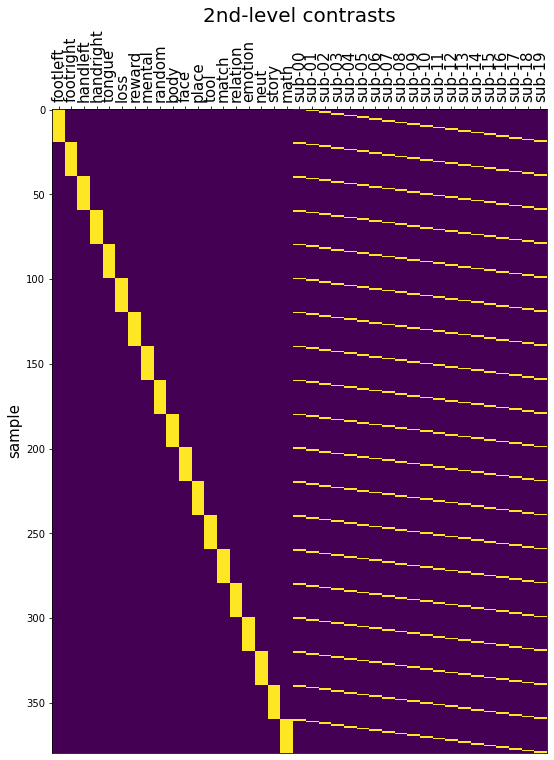

In [61]:
# set up the 2nd-level contrast matrix
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix
n_subs = 20
n = len(test_img_files)
design_matrix = {}

for label in range(len(class_labels)):
    regressor = np.repeat(np.eye(len(class_labels))[label], n_subs)
    #regressor[np.where(regressor==0)] = -1/len(class_labels)
    design_matrix[f'{class_labels[label]}'] = regressor

#design_matrix['average'] = np.ones(n) # the average across al conditions simply takes all files as input
    
for sub in range(n_subs):
    regressor = np.tile(np.eye(n_subs)[sub], len(class_labels))
    design_matrix[f'sub-{sub:02d}'] = regressor

df_design_matrix = pd.DataFrame(design_matrix)
fig, ax = plt.subplots(figsize=(8, 10))
plot_design_matrix(df_design_matrix, rescale=False, ax=ax);
ax.set_xticklabels(df_design_matrix.columns, fontsize=15, rotation=90, ha="center");
ax.set_ylabel("sample", fontsize=15);
ax.xaxis.set_label_position('top') 
ax.set_title("2nd-level contrasts", fontsize=20);

#plt.savefig('figures/2nd-level-matrix-nilearn.svg', facecolor=fig.get_facecolor(), transparent=True)

In [62]:
# create the glm
glm = SecondLevelModel(smoothing_fwhm=None, mask_img=mask)

In [63]:
# perform the GLM once on the original beta maps
glm.fit([nilearn.image.index_img(images, i) for i in range(n)], design_matrix=df_design_matrix)

contrasts = class_labels

for c, contrast in enumerate(contrasts):
    maps_orig = glm.compute_contrast(contrast, output_type="all")
    save_stat_maps(maps_orig, f"{contrast}", save_loc="stat-maps/orig")

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


In [64]:
# perform the GLM on the relevance maps for each individual fold
# load the relevance images
contrasts = class_labels

attr_types = ["lrp", "guidedbackprop"] #"lrp" "guidedbackprop"

label_order = "real" #, "shuffled"

overwrite = False

BEST_FOLD = 1
fold = BEST_FOLD

for a, attr_type in enumerate(attr_types):

    print(attr_type, label_order, fold)

    save_loc = os.path.join("stat-maps", attr_type, label_order, f"seed-2020_fold-{fold:02d}")

    if not os.path.isdir(save_loc) or overwrite:

        relevance_files = glob(os.path.join(f"{attr_type}", label_order, f"seed-2020_fold-{fold:02d}/*.nii.gz"))
        relevance_maps = load_img(relevance_files)

        # set up the GLM for the current fold
        glm.fit([nilearn.image.index_img(relevance_maps , i) for i in range(n)], design_matrix=df_design_matrix)

        for c, contrast in enumerate(contrasts):
            maps_attr = glm.compute_contrast(contrast, output_type="all")
            save_stat_maps(maps_attr, f"{contrast}", save_loc=save_loc)


lrp real 1
guidedbackprop real 1


### Leave-one-subject-out grp maps

Now that we have the group LRP, GBP, and t-maps, we can turn to the leave-one-subject-out tests. We need these group statistics as well to be unbiased in computing the sub(attr/t) vs group(attr/t) mutual information. 

In [65]:
contrasts = class_labels

sub_list = np.tile(np.arange(n_subs), len(contrasts))

for s in tqdm(range(n_subs)):
    
    # copy the original design matrix
    this_dm = df_design_matrix.copy()
    
    # now drop the respective subject
    this_dm = this_dm.drop(labels=np.squeeze(np.where(sub_list == s)), axis="index")
    this_dm = this_dm.drop(columns=[f"sub-{s:02d}"])
    #plot_design_matrix(this_dm)
    
    idcs = np.arange(n)
    idcs = np.delete(idcs, np.where(sub_list == s))
    
    # perform the GLM on the all subs except s
    glm.fit([nilearn.image.index_img(images, i) for i in idcs], design_matrix=this_dm)

    for c, contrast in enumerate(contrasts):
        maps_orig = glm.compute_contrast(contrast, output_type="all")
        save_stat_maps(maps_orig, f"{contrast}_wo-sub{s:02d}", save_loc="stat-maps/orig/left-out", maps_of_interest=["z_score"])

  0%|          | 0/20 [00:00<?, ?it/s]

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/

# compute a GLM for the test data set by leaving 1-subject out. We will need this for the mutual information analysis later


In [66]:
# COMPUTE THE GLM FOR EACH FOLD BUT LEAVE OUT ONE SUBJECT AT A TIME
# perform the GLM on the relevance maps for each individual fold
# load the relevance images
contrasts = class_labels

attr_types = ["lrp", "guidedbackprop"] #"lrp" "guidedbackprop"

label_orders = "real" #, "shuffled"

overwrite = False

# we just want to do it for the best performing fold, which is number 6 in this case
fold = BEST_FOLD

sub_list = np.tile(np.arange(n_subs), len(class_labels))

for a, attr_type in enumerate(attr_types):
        
    print(attr_type, label_order)
            
    save_loc = os.path.join("stat-maps", attr_type, label_order, f"seed-2020_fold-{fold:02d}", "left-out")

    if not os.path.isdir(save_loc) or overwrite:

        # load the files for a given fold
        relevance_files = glob(os.path.join(attr_type, label_order, f"seed-2020_fold-{fold:02d}/*.nii.gz"))
        relevance_maps = load_img(relevance_files)

        for s in tqdm(range(n_subs), leave=False, desc="subs"):

            # copy the original design matrix
            this_dm = df_design_matrix.copy()

            # now drop subject s from the design matrix
            this_dm = this_dm.drop(labels=np.squeeze(np.where(sub_list == s)), axis="index")
            this_dm = this_dm.drop(columns=[f"sub-{s:02d}"])

            # remove the subject s' indices from the data list
            idcs = np.arange(n)
            idcs = np.delete(idcs, np.where(sub_list == s))

            # perform the GLM on the all subs except s
            glm.fit([nilearn.image.index_img(relevance_maps, i) for i in idcs], design_matrix=this_dm)

            for c, contrast in enumerate(contrasts):
                maps_orig = glm.compute_contrast(contrast, output_type="all")
                save_stat_maps(maps_orig, f"{contrast}_wo-sub{s:02d}", save_loc=save_loc, maps_of_interest=["z_score"])

lrp real


subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

subs:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

## SANITY CHECKS FOR RELEVANCE/XAI
### OCCLUSION (faithfulness test)

Let us first establish a baseline by removing the most important voxels, as deemed by a linear SVM. 
We can then compare the faitfhulness of a the SVM, e.g., LRP and GuidedBackPropagation.


In [16]:
from delphi.utils.tools import occlude_images
from utils.tools import run_pca, run_svm, predict
import pickle as pk
from nilearn.masking import apply_mask

In [17]:
def occlude_images(images, attributions, mask, fraction=1, get_fdata=False) -> nib.Nifti1Image:
    """

    Args:
        images:
        attributions:
        mask:
        fraction:   voxel percentage to occlude (default=1%)
        get_fdata:  in case one wants to get the numpy arrays already.

    Returns:

    """
    from nilearn.masking import apply_mask, unmask

    fraction = fraction / 100

    # mask the images such that we only really consider brain voxels
    images_masked = apply_mask(images, mask)
    attributions_masked = apply_mask(attributions, mask)

    # find the indices of the largest n voxels for each attribution image (number depends on fraction)
    if len(attributions_masked.shape) < 2:
        occlusion_indices = np.argsort(a=attributions_masked)[::-1]  # this means we find the largest.
        occlusion_indices = occlusion_indices[:int(fraction * occlusion_indices.shape[-1])]
    else:
        occlusion_indices = np.argsort(a=attributions_masked, axis=1)[:, ::-1]  # this means we find the largest.
        occlusion_indices = occlusion_indices[:, :int(fraction * occlusion_indices.shape[-1])]

    # dummy for occluded images
    occluded_images = np.array(images_masked)
    occluded_images[:, occlusion_indices] = 0

    # convert the occluded_images back into 3d nibabel format
    if not get_fdata:
        return unmask(occluded_images, mask), occlusion_indices.shape[-1]
    else:
        return unmask(occluded_images, mask).get_fdata(), occlusion_indices.shape[-1]

In [36]:
class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]

percentages = np.concatenate([
    np.arange(0, 2, .2),
    np.arange(2, 5, .5),
    np.arange(5, 10, 1),
    np.arange(10, 32, 2)
])

mask = mni_template

In [37]:
images = []
for c, label in tqdm(enumerate(class_labels), leave=False, desc="class"):
    images.append(load_img(glob(f"../t-maps/test/{label}/*.nii.gz")))

class: 0it [00:00, ?it/s]

In [38]:
# load the decision boundary maps (i.e., the weight maps of the SVM; we can consider those to be the "explanation" of the SVM)
n_folds = 7
df_svm = []
real = np.repeat(np.arange(19), 20)

for f in range(n_folds):
    
    svm_files = load_img(f"../00_svm/svm_maps/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.nii.gz")
    pca_file = f"../00_svm/pca_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_2280samples_seed{2020+f}.pkl"
    with open(pca_file, 'rb') as pickle_file:
        pca = pk.load(pickle_file)

    svm_file = f"../00_svm/svm_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.pkl"
    with open(svm_file, 'rb') as pickle_file:
        svm = pk.load(pickle_file)

    accs = np.zeros(len(percentages))   

    for i, frac in tqdm(enumerate(percentages), leave=False, desc="fractions"):
        occluded = []
        for c, label in tqdm(enumerate(class_labels), leave=False, desc="class"):
            # load the data
            occu, _ = occlude_images(images[c], nilearn.image.index_img(svm_files , c), mask, fraction=frac, get_fdata=False)
            occluded.append(occu)
        occluded = nilearn.image.concat_imgs(occluded)
        occluded = apply_mask(occluded, mni_template)
        # transform the data
        occluded = pca.transform(occluded)
        _, accs[i] = predict(svm, occluded, real)

    df_svm.append(pd.DataFrame(accs.tolist(), columns=["accuracy"]))
    df_svm[f]["algorithm"] = "svm"
    df_svm[f]["prct_occluded"] = percentages
    df_svm[f]["fold"] = fold

df_stacked = pd.concat(df_svm)
df_stacked.to_csv("stats/svm_occlusion_curves.csv", index=False)

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

In [54]:
# load the t-scores for each subject
test_img_files = []
[test_img_files.extend(glob(f"../t-maps/test/{class_labels[i]}/*.nii.gz")) for i in range(len(class_labels))]
images = load_img(test_img_files)

In [45]:
xai_algo = ["lrp", "guidedbackprop"]
df_occlu = []

real = np.repeat(np.arange(len(class_labels)), 20)

n_folds = 7

if not os.path.isfile("stats/occlusion_curves.csv"):

    
    for fold in range(n_folds):
        # load the trained network
        model = BrainStateClassifier3d(f"models/hcp-train-real/seed-2020_fold-{fold:02d}")
        model.eval()
        model.to(torch.device("cpu"));

        for i, algo in enumerate(xai_algo):

            #folds = sorted(glob(os.path.join(algo, "real", "*fold*")))

            #for f, fold in enumerate(folds):
            relevance_files = glob(os.path.join(algo, "real", f"*fold-{fold:02d}", "*.nii.gz"))
            relevance_maps = load_img(relevance_files)

            accs = np.zeros(len(percentages))

            for i, frac in tqdm(enumerate(percentages), leave=False, desc="fractions"):
                occluded, _ = occlude_images(images, relevance_maps, mask, fraction=frac, get_fdata=True)
                occluded = np.moveaxis(occluded, -1, 0)
                occluded = torch.tensor(occluded).unsqueeze(1)
                pred = np.argmax(model(occluded.float()).detach().cpu().numpy(), axis=1)
                accs[i] = compute_accuracy(real, pred)

            df_inter = pd.DataFrame(accs.tolist(), columns=["accuracy"])
            df_inter["algorithm"] = algo
            df_inter["prct_occluded"] = percentages
            df_inter["fold"] = fold

            df_occlu.append(df_inter)

    df_occlusion = pd.concat(df_occlu)
    df_occlusion.to_csv("stats/occlusion_curves.csv", index=False)
else:
    df_occlusion = pd.read_csv("stats/occlusion_curves.csv")

Loading from config file models/hcp-train-real/seed-2020_fold-00/config.yaml


fractions: 0it [00:00, ?it/s]

fractions: 0it [00:00, ?it/s]

Loading from config file models/hcp-train-real/seed-2020_fold-01/config.yaml


TypeError: Cannot concatenate empty objects

In [44]:
df_occlu

[]

In [ ]:
df_occlusion = pd.concat([df_stacked, df_occlusion])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(ax=ax, data=df_occlusion, x="prct_occluded", y="accuracy", hue="algorithm", alpha=.4, legend=False, zorder=0)
sns.lineplot(ax=ax, data=df_occlusion, x="prct_occluded", y="accuracy", hue="algorithm", style="algorithm", 
             errorbar=("ci", 95), n_boot=1000, linewidth=2, markers=True, markersize=10)
ax.axhline(1/19, color="black", linestyle="--", zorder=0)
ax.legend(frameon=False, loc="center right", fontsize=18, title="attribution method")
ax.spines[["top", "right"]].set_visible(False)

plt.savefig("figures/occlusion_curves.pdf", facecolor=fig.get_facecolor(), transparent=True)

288

# Identify the best fold

In [ ]:
from utils.wandb_funcs import get_wandb_csv

In [ ]:
keys_of_interest = ['group', 'job_type', 'run_name', 'test_accuracy', 'train_acc', 'valid_acc', 
                    'valid_loss', 'best_valid_epoch', 'best_valid_accuracy', 'test_loss', 'train_loss']
wandb_df = get_wandb_csv("philis893", "thesis", "first-steps-motor", keys_of_interest, overwrite=True)

In [ ]:
real_runs = wandb_df[wandb_df.job_type == "CV-motor"]
# sort according to best_valid_accuracy (desc), test_accuracy (desc), and test_loss (asc). Take the first entry => best fold
real_runs_sorted = real_runs.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
real_runs_sorted.head(1)

In [ ]:
best_fold = 9;

# Compute and investigate mutual information between different combination of attribution- and (group) t-maps

Mutual information can help us understand how similar the attribution maps of the LRP or GBP algorithm are to the original data format, i.e., t-statistics maps of single subjects or of the group. 

We can further perform some sanity checks this way:
* Comparing attribution maps obtained by networks trained with real input-label mappings to those with shuffled mappings can tell us something about the sensitivity to network parameters
* Comparing attribution maps to t-maps of single subjects or to the group t-maps allows us to judge how well the attribution maps reflect univariate statistics (may not be so fair because CNNs are multivariate!)
* We can see whether LRP or GBP has higher better mutual information to the original input data.

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from nilearn.masking import apply_mask
from nilearn.image import load_img

In [ ]:
mask = "stat-maps/motor_mask.nii.gz"
#mask = mni_template
contrasts = ["subattr-vs-grpattr", "subt-vs-grpt", "subattr-vs-grporig", "grpattr-vs-grporig"]
for i, contrast in enumerate(contrasts):
    test = compute_mi(TASK_LABEL, class_labels, mask, "mi_motor-mask", n_folds=10, attr_methods=["lrp", "guidedbackprop"], contrast=contrast)

In [ ]:
# do it for the trained model vs rnd model
contrast = "model-trained-vs-rnd"
methods = ["lrp", "guidedbackprop"]
seed = 2020

mis_list = []
mask = mni_template
for m, method in enumerate(methods):
    
    
    for c, lbl in enumerate(class_labels):
        X = apply_mask(f"{method}/model-random/motor_fold-00/{lbl}.nii.gz", mask)
        y = apply_mask(f"{method}/real/motor_fold-09/{lbl}.nii.gz", mask)
        
        mi = np.zeros(len(X))
        
        for i in range(len(X)):
            mi[i] = mutual_info_regression(X=X[i, :].reshape(-1, 1), y=y[i, :],
                                           discrete_features=False, random_state=seed)
        mis_list.append(
            pd.DataFrame({"mi": mi.tolist(), "class": lbl, "fold": fold,
                          "attr_method": method, "contrast": contrast}))

mis = pd.concat(mis_list)
mis.to_csv(f"stats/mi_whole-brain_{contrast}.csv", index=False)

## Plot the mutual information scores for the sanity checks (i.e., model trained vs model rnd; real labels vs shuffled labels)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

mis = pd.read_csv("stats/mi_whole-brain_attr-real-vs-shuffled.csv")
sns.boxenplot(ax=axes[0], data=mis, x="class", y="mi", hue="attr_method")
axes[0].set_title("data randomization test");

mis = pd.read_csv("stats/mi_whole-brain_model-trained-vs-rnd.csv")
sns.boxenplot(ax=axes[1], data=mis, x="class", y="mi", hue="attr_method")
axes[1].set_title("model randomization test");

for i, ax in enumerate(axes.flatten()):
    if i == 1:
        ax.legend(frameon=False, title="attribution method")
    else:
        ax.legend([],[], frameon=False)
    ax.spines[["top", "right"]].set_visible(False)

## Plot the mutual information scores for different comparisons

In [ ]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
f"stats/mi_{m}_{contrast}.csv"

In [ ]:
axes.flatten()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 1.3, .8]})

masks = ["whole-brain", "motor-mask"]

for i, m in enumerate(masks):
    # grpAttr vs grpOrig
    contrast = "grpattr-vs-grporig"
    df = pd.read_csv(f"stats/mi_{m}_{contrast}.csv")
    df = df[df.fold==best_fold]
    sns.barplot(ax=axes[i, 0], data=df, x="class", y="mi", hue="attr_method")
    axes[i, 0].set_ylabel("$MI_{(GrpAttrMethod, GrpOrig)}$")

    # sub vs grp
    contrasts = ["subattr-vs-grpattr"]
    dfs = []
    for c, contrast in enumerate(contrasts):
        this_df = pd.read_csv(f"stats/mi_{m}_{contrast}.csv")
        # filter for best fold
        best_fold_df = this_df[this_df.fold == best_fold].copy()
        dfs.append(best_fold_df)
        dfs[c]["contrast"] = contrast

    dfs.append(pd.read_csv(f"stats/mi_{m}_subt-vs-grpt.csv"))
    dfs[-1]["contrast"] = "subattr-vs-subt"

    df = pd.concat(dfs)

    sns.boxenplot(ax=axes[i, 1], data=df, x="class", hue="attr_method", y="mi", k_depth="trustworthy")
    axes[i, 1].set_ylabel("$MI_{(SubMethod, GrpMethod)}$")

    sns.boxenplot(ax=axes[i, 2], data=df, x="attr_method", y="mi", k_depth="trustworthy")
    axes[i, 2].set_ylabel("$MI_{(SubMethod, GrpMethod)}$")

for i, ax in enumerate(axes.flatten()):
    if i == 1:
        ax.legend(frameon=False, title="attribution method")
    else:
        ax.legend([],[], frameon=False)
    ax.spines[["top", "right"]].set_visible(False)

fig.tight_layout()